# Statistics

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob 
import pickle
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn import dummy

sns.set('notebook', 'white')

df_all_ = None
for result_file in glob('data/results/*.npy'):
    with open(result_file, 'rb') as f:
        result = pickle.load(f)
    dataset = result_file.split('/')[-1].rsplit('.', 2)[0]
    is_graph_dataset = 'graph' in dataset
    is_cooccurrence_dataset = 'cooccurrence' in dataset
    dataset_name = dataset
    if is_graph_dataset:
        is_relabeled = 'relabeled' in result_file
        result['relabeled'] = is_relabeled
        if is_relabeled:
            # dataset_graph_cooccurrence_1_all_relabeled_threshold_topn-1_threshold-0.5_ling-spam.phi.npy.0.results.npy
            topn = result_file.split('topn-')[1].split('_')[0]
            threshold = result_file.split('threshold-')[1].split('_')[0]
            result['topn'] = int(topn)
            result['threshold'] = float(threshold)
        result['wl_iteration'] = int(dataset.split('.')[-1])
        parts = dataset.split('_')
        if is_cooccurrence_dataset:
            dataset_name = parts[-1].split('_')[0].split('.')[0]
            result['words'] = parts[4]
            result['window_size'] = parts[3]
        # GML
        else:
            dataset_name = parts[3].split('.')[0]
            result['words'] = 'concepts'
        result['type'] = 'cooccurrence' if is_cooccurrence_dataset else 'concept-graph'
    else:
        result['type'] = 'text'
        dataset_name = dataset.split('_')[1]
        result['words'] = ['all' if x['preprocessing'] != None else 'only-nouns'  for x in result['params']]
        #result['words'] = result['params']['preprocessing']
    result['classifier'] = [None] * len(result['params'])
    for idx, param in enumerate(result['params']):
        is_dummy = isinstance(param['clf'], sklearn.dummy.DummyClassifier)
        result['classifier'][idx] = type(param['clf']).__name__
        del param['clf']
    result['filename'] = result_file
    if dataset_name.endswith('-single'):
        dataset_name = dataset_name.rsplit('-', 1)[0]
    del result['param_clf']
    result['dataset'] = dataset_name
    result_df = pd.DataFrame(result).sort_values(by = 'dataset', ascending = False)
    if df_all_ is None:
        df_all_ = result_df
    else:
        df_all_ = df_all_.append(result_df)
#df_all['window_size'].fillna('concept-graph', inplace = True)

#df_all_['threshold'] = 
df_all_['threshold'] = pd.to_numeric(df_all_['threshold'])

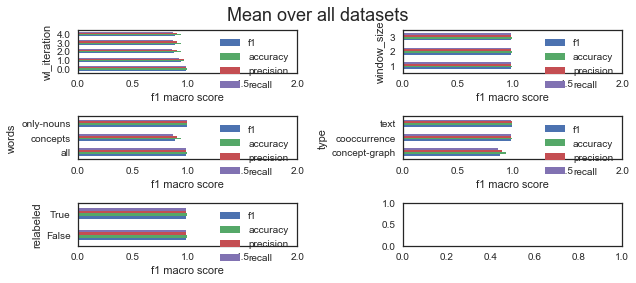

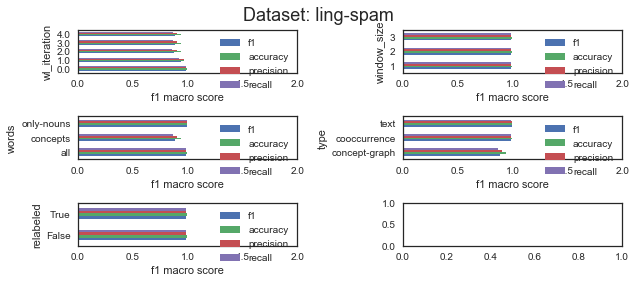

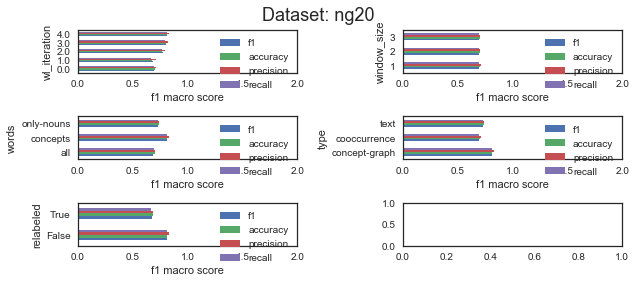

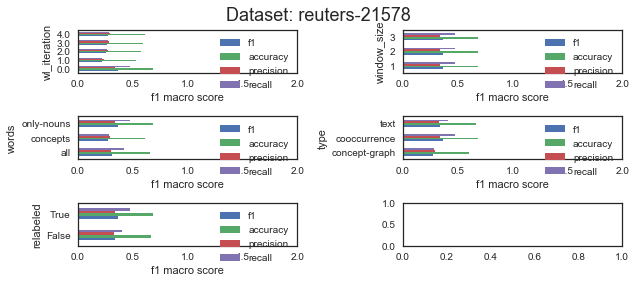

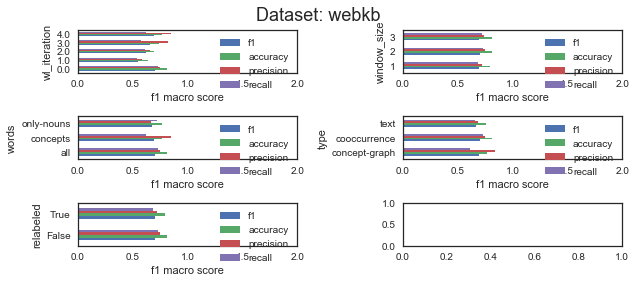

In [4]:
sns.set('notebook', 'white')
def plot_distributions(df, df_all, title = None, figsize = (9, 4)):
    fig, axes_indexed = plt.subplots(nrows = 3, ncols=2, figsize = figsize)

    axes = []
    for ax_row in axes_indexed:
        axes += list(ax_row)
    for val, ax in zip(['wl_iteration', 'window_size', 'words', 'type', 'relabeled'], axes):
        if len(df.groupby(val).size()) == 0:
            continue
        grouped = df.groupby(val)
        els = df_all.iloc[grouped['mean_test_f1_macro'].idxmax()]
        els = els.set_index(val)
        els = els.rename(columns = {'mean_test_f1_macro': 'f1', 'mean_test_accuracy': 'accuracy', 'mean_test_precision_macro': 'precision', 'mean_test_recall_macro': 'recall'})
        els[['f1', 'accuracy', 'precision', 'recall']].plot(kind = 'barh', ax = ax, xlim=(0, 2))
        #df.groupby(val).mean_test_f1_macro.mean().plot(kind = 'barh', ax = ax, xlim = (0, 1))
        ax.set_xlabel('f1 macro score')
    plt.suptitle(title, size = 18)
    fig.tight_layout()
    fig.subplots_adjust(top=0.90)
    return fig, axes
    
dpi = 150
df_all = df_all_.groupby('dataset').filter(lambda x: len(x.type.value_counts()) == 3).reset_index(drop=True)
fig, _  = plot_distributions(df_all, df_all, title = 'Mean over all datasets')
fig.savefig('tmp/results/all.png', dpi = dpi)
plt.show()
plt.close(fig)
for name, df_dataset in df_all.groupby('dataset'):
    if len(df_dataset.type.value_counts()) < 3:
        continue
    fig, _ = plot_distributions(df_dataset, df_all, title = 'Dataset: {}'.format(name))
    fig.savefig('tmp/results/dataset-{}.png'.format(name), dpi = dpi)
    plt.show()
    plt.close(fig)


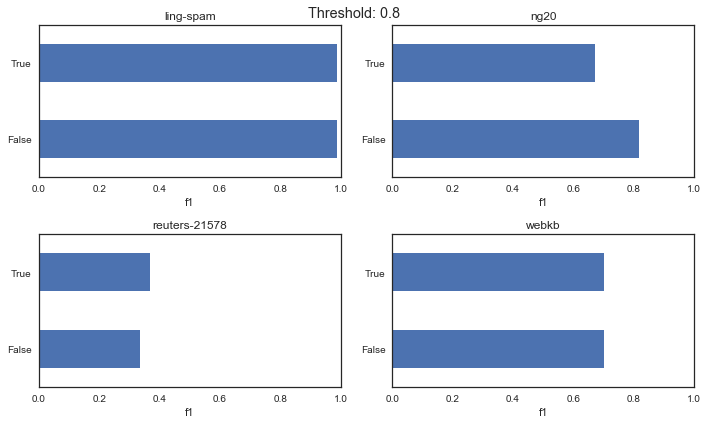

In [9]:
df_all[df_all.classifier == 'DummyClassifier'].groupby('dataset').mean_test_f1_macro.max()
df_graphs_grouped = df_all[df_all.type != 'text'].groupby('dataset')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (10, 6))
for idx, (dataset_name, df_dataset) in enumerate(df_graphs_grouped):
    ax = axes[int(idx / 2), idx % 2]
    grouped = df_dataset.groupby('relabeled')
    els = df_all.iloc[grouped.mean_test_f1_macro.idxmax()]
    els = els.set_index('relabeled')
    #threshold = els[els.threshold > 0].iloc[0].threshold
    els = els.rename(columns = {'mean_test_f1_macro': 'f1', 'mean_test_accuracy': 'accuracy', 'mean_test_precision_macro': 'precision', 'mean_test_recall_macro': 'recall'})
    els[['f1']].plot(kind = 'barh', ax = ax, legend = False, xlim = (0, 1), title = dataset_name)
    ax.set_xlabel('f1')
    ax.set_ylabel('')

fig.tight_layout()
fig.suptitle('Threshold: {}'.format(0.8))
fig.savefig('tmp/results/relabeled.png', dpi = 150)
plt.show()
#df_all.iloc[]
#df_all[df_all.type != 'text'].groupby('dataset').mean_test_f1_macro.max().to_frame()

ling-spam
concept-graph       best f1-score: 0.8852	words: concepts      wl iteration: 4        relabeled: 0     
cooccurrence        best f1-score: 0.9863	words: all           wl iteration: 0        relabeled: 0     window_size: 1
text                best f1-score: 0.9919	words: only-nouns    stop words:   english


,classifier,dataset,filename,mean_fit_time,mean_score_time,accuracy,f1,precision,recall,mean_train_accuracy,...,std_test_recall_macro,std_train_accuracy,std_train_f1_macro,std_train_precision_macro,std_train_recall_macro,threshold,topn,window_size,wl_iteration,words
type,,,,,,,,,,,,,,,,,,,,,
concept-graph,PassiveAggressiveClassifier,ling-spam,data/results/dataset_graph_gml_ling-spam-singl...,0.067903,0.054046,0.943156,0.885181,0.907753,0.866553,1.00000,...,0.007132,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,4.0,concepts
cooccurrence,PassiveAggressiveClassifier,ling-spam,data/results/dataset_graph_cooccurrence_1_all_...,0.470915,0.035055,0.992395,0.986293,0.985581,0.987116,0.99758,...,0.005744,0.000882,0.001572,0.003136,0.000147,NaN,NaN,1,0.0,all
text,PassiveAggressiveClassifier,ling-spam,data/results/text_ling-spam.results.npy,5.378524,7.745638,0.995506,0.991887,0.992360,0.991478,1.00000,...,0.003290,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,only-nouns


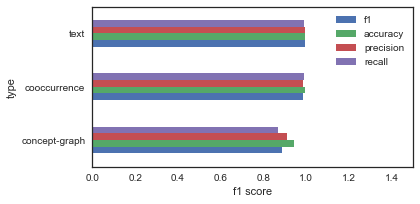

ng20
concept-graph       best f1-score: 0.8166	words: concepts      wl iteration: 4        relabeled: 0     
cooccurrence        best f1-score: 0.6978	words: only-nouns    wl iteration: 0        relabeled: 0     window_size: 1
text                best f1-score: 0.7305	words: only-nouns    stop words:   english


,classifier,dataset,filename,mean_fit_time,mean_score_time,accuracy,f1,precision,recall,mean_train_accuracy,...,std_test_recall_macro,std_train_accuracy,std_train_f1_macro,std_train_precision_macro,std_train_recall_macro,threshold,topn,window_size,wl_iteration,words
type,,,,,,,,,,,,,,,,,,,,,
concept-graph,PassiveAggressiveClassifier,ng20,data/results/dataset_graph_gml_ng20-single.phi...,3.259305,0.199206,0.815645,0.816618,0.831735,0.811305,0.999221,...,0.002586,0.000191,0.000188,0.000195,0.000181,NaN,NaN,NaN,4.0,concepts
cooccurrence,PassiveAggressiveClassifier,ng20,data/results/dataset_graph_cooccurrence_1_only...,8.866196,0.399635,0.705242,0.697774,0.712138,0.694557,0.944683,...,0.000195,0.001175,0.001020,0.000141,0.000967,NaN,NaN,1,0.0,only-nouns
text,PassiveAggressiveClassifier,ng20,data/results/text_ng20.results.npy,22.024475,22.425198,0.737822,0.730457,0.737148,0.728683,0.971268,...,0.002771,0.001204,0.000972,0.000556,0.001165,NaN,NaN,NaN,NaN,only-nouns


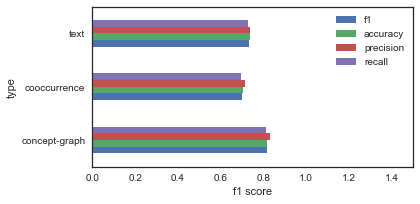

reuters-21578
concept-graph       best f1-score: 0.2802	words: concepts      wl iteration: 4        relabeled: 0     
cooccurrence        best f1-score: 0.3674	words: only-nouns    wl iteration: 0        relabeled: 1     window_size: 2
text                best f1-score: 0.3408	words: only-nouns    stop words:   english


,classifier,dataset,filename,mean_fit_time,mean_score_time,accuracy,f1,precision,recall,mean_train_accuracy,...,std_test_recall_macro,std_train_accuracy,std_train_f1_macro,std_train_precision_macro,std_train_recall_macro,threshold,topn,window_size,wl_iteration,words
type,,,,,,,,,,,,,,,,,,,,,
concept-graph,PassiveAggressiveClassifier,reuters-21578,data/results/dataset_graph_gml_reuters-21578-s...,6.979017,0.496345,0.608669,0.280204,0.290936,0.287385,0.871242,...,0.014326,0.001841,0.012507,0.018142,0.012231,NaN,NaN,NaN,4.0,concepts
cooccurrence,LinearSVC,reuters-21578,data/results/dataset_graph_cooccurrence_2_only...,14.026196,0.118615,0.684799,0.367410,0.337566,0.480586,0.754494,...,0.020977,0.003102,0.008767,0.006615,0.013645,0.9,1.0,2,0.0,only-nouns
text,PassiveAggressiveClassifier,reuters-21578,data/results/text_reuters-21578.results.npy,38.625000,17.516521,0.673019,0.340805,0.334626,0.412094,0.834778,...,0.009343,0.003509,0.013708,0.014087,0.012483,NaN,NaN,NaN,NaN,only-nouns


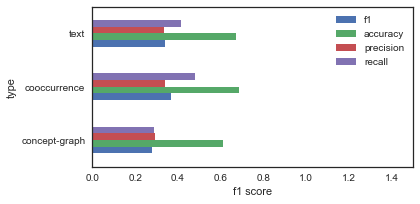

webkb
concept-graph       best f1-score: 0.6933	words: concepts      wl iteration: 4        relabeled: 0     
cooccurrence        best f1-score: 0.7026	words: all           wl iteration: 0        relabeled: 0     window_size: 2
text                best f1-score: 0.6667	words: only-nouns    stop words:   english


,classifier,dataset,filename,mean_fit_time,mean_score_time,accuracy,f1,precision,recall,mean_train_accuracy,...,std_test_recall_macro,std_train_accuracy,std_train_f1_macro,std_train_precision_macro,std_train_recall_macro,threshold,topn,window_size,wl_iteration,words
type,,,,,,,,,,,,,,,,,,,,,
concept-graph,PassiveAggressiveClassifier,webkb,data/results/dataset_graph_gml_webkb-single.ph...,1.032053,0.058803,0.764758,0.693296,0.845138,0.618357,0.998242,...,0.030462,0.000475,0.001232,0.002003,0.000417,NaN,NaN,NaN,4.0,concepts
cooccurrence,PassiveAggressiveClassifier,webkb,data/results/dataset_graph_cooccurrence_2_all_...,6.337555,0.293449,0.815688,0.702576,0.750002,0.728812,0.919205,...,0.014137,0.000781,0.009991,0.001304,0.016568,NaN,NaN,2,0.0,all
text,PassiveAggressiveClassifier,webkb,data/results/text_webkb.results.npy,11.517793,18.074373,0.763597,0.666677,0.684884,0.660261,0.993111,...,0.004341,0.002383,0.007526,0.012771,0.001095,NaN,NaN,NaN,NaN,only-nouns


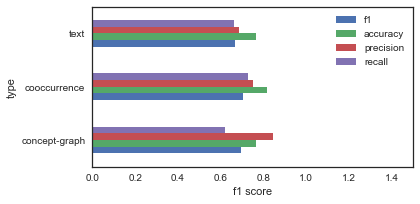

In [6]:
def plot_best_by_type(df_all, df, title = '', fontsize = 12, figsize = (6, 3), top = 0.85):
    fig, ax = plt.subplots(figsize = figsize)
    els = df_all.iloc[df['mean_test_f1_macro'].idxmax()]
    els = els.set_index('type')
    els = els.rename(columns = {'mean_test_f1_macro': 'f1', 'mean_test_accuracy': 'accuracy', 'mean_test_precision_macro': 'precision', 'mean_test_recall_macro': 'recall'})
    els[['f1', 'accuracy', 'precision', 'recall']].plot(kind = 'barh', ax = ax, xlim = (0, 1.5))
    #    df['mean_test_f1_macro'].max().plot(kind = 'barh', ax = ax, xlim = (0, 1))#, xerr=els.std_test_f1_macro * 2)
    ax.set_xlabel('f1 score')
    for set_type, x in els.iterrows():
        out = '{:20}best f1-score: {x.f1:.4f}\twords: {x.words:14}'.format(set_type, x = x)
        if set_type != 'text':
            out += 'wl iteration: {x.wl_iteration:<8.0f} relabeled: {x.relabeled:<6}'.format(x = x)
        else:
            out += 'stop words:   {}'.format(x.params["count_vectorizer__stop_words"])
        if set_type == 'cooccurrence':
            out += 'window_size: {x.window_size}'.format(x = x)
        print(out)
    display(els)
    if title and title != '':
        fig.suptitle(title, fontsize = fontsize)
    fig.tight_layout()
    if title and title != '':
        fig.subplots_adjust(top = top)
    return fig, ax

for name, df_dataset in sorted(df_all.groupby('dataset'), key = lambda x: x[0]):
    df_dataset_grouped_by_type = df_dataset.groupby('type')
    print(name)
    use_title = False
    fig, ax = plot_best_by_type(df_all, df_dataset_grouped_by_type, 'Dataset: {}'.format(name) if use_title else None)
    fig.savefig('tmp/results/dataset-{}-best.png'.format(name), dpi = 150)
    plt.show()
    plt.close(fig)


In [7]:
import json

with open('data/check-w2v-results.json') as f:
    w2v_results = json.load(f)
 
per_embedding_type = {}
for dataset, value in w2v_results.items():
    print(dataset)
    for embedding_raw, cache_files in sorted(value.items(), key = lambda x: x[0]):
        embedding = embedding_raw.split('/')[-1].rsplit('.', 2)[0]
        if len(cache_files.keys()) != 2: continue
        print('\t{}'.format(embedding))
        if embedding not in per_embedding_type:
            per_embedding_type[embedding] = {}
        per_embedding_type[embedding][dataset] = []
        for dataset_file, counts in sorted(cache_files.items(), key = lambda x: x[0]):
            not_found_ratio = int(counts['counts']['not_found'] / counts['num_labels'] * 100)
            if embedding == 'trained' and 'coo' in  dataset_file:
                print('Yes', counts['counts']['not_found'], not_found_ratio, '%', counts['not_found_sample'])
            is_gml = 'dataset_graph_gml' in dataset_file
            per_embedding_type[embedding][dataset].append((is_gml, not_found_ratio))
            print('\t\t{:4} missing  {:3>}%'.format('gml' if is_gml else 'co', not_found_ratio))
        per_embedding_type[embedding][dataset] = per_embedding_type[embedding][dataset][0][1]  #sum(y for x, y in per_embedding_type[embedding][dataset]) / 2
df = pd.DataFrame(per_embedding_type)
df#[df.index == "ng20"]

FileNotFoundError: [Errno 2] No such file or directory: 'data/check-w2v-results.json'

In [ ]:
import dataset_helper
import matplotlib.pyplot as plt

currently = ['ling-spam', 'webkb', 'ng20', 'reuters-21578']

for dataset in dataset_helper.get_all_available_dataset_names():
    if dataset in currently: continue
    print(dataset)
    continue
    X, Y = dataset_helper.get_dataset(dataset)
    dataset_helper.plot_dataset_class_distribution(X, Y, 'Class distribution: {}'.format(dataset))
    plt.show()
    print('{}\n#Docs:\t{}\t# Classes:\t{}'.format(dataset, len(X), len(set(Y))))